# Support Vector Machines (SVM)

Support vector machines (SVMs) are a class of supervised algorithms for classification and regression.

They're not used much anymore compared to decision trees and deepnets, but they're worth seeing just for general culture.

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', None)

In [42]:
dftime['Time'] = df['Start Time'].str[11:13]

In [44]:
dftime.value_counts('Time')
#this shows me that most tornadoes happen at night, between 18:00 - 04:00

Time
22    260
23    242
21    231
00    213
20    186
01    174
19    132
02    131
03     79
18     79
04     68
17     66
06     57
05     55
10     53
11     52
07     49
08     45
09     44
12     43
16     42
13     38
14     33
15     29
Name: count, dtype: int64

In [2]:
df = pd.read_csv('data/EFtornadoes.csv')

In [3]:
df = df.dropna()
df = df.drop(df[df['Rating'].isin(['F0', 'F1', 'F2'])].index)
#the rating officially switched in 2007 but a few from January 2007 were still classified as F

In [4]:
df

,ID,Countries,States,Start Time,Start Latitude,Start Longitude,End Latitude,End Longitude,Rating,Path Length (mi),Path Width (yds),Injuries,Fatalities,Comments,Sources
30,SPC49316_NCEI18948-17515,US,FL,2007-02-02T08:10:00Z,28.882,-82.046,28.918,-81.783,EF3,16.20,450.0,25,8.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...
31,SPC49317_NCEI18950-20318,US,FL,2007-02-02T08:37:00Z,28.959,-81.587,29.039,-81.163,EF3,26.00,450.0,51,13.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...
32,SPC49318_NCEI19002,US,FL,2007-02-02T09:22:00Z,29.064,-80.989,29.073,-80.942,EF1,3.10,100.0,0,0.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...
33,SPC49319_NCEI12846,US,FL,2007-02-02T13:00:00Z,27.730,-81.530,27.730,-81.530,EF0,0.50,50.0,0,0.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...
36,SPC49320_NCEI17968,US,LA,2007-02-13T06:10:00Z,30.110,-92.020,30.140,-92.010,EF1,2.20,50.0,0,0.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24734,RV13452023USA,US,AL,2023-12-10T10:36:00Z,32.465,-85.426,32.474,-85.386,EF0,2.43,400.0,0,0.0,The National Weather Service surveyed in south...,NWS Storm Survey
24735,RV13462023USA,US,FL,2023-12-10T11:30:00Z,30.805,-85.833,30.829,-85.792,EF1,2.97,250.0,0,0.0,A tornado touched down just east of the Chatta...,NWS Storm Survey
24736,RV13472023USA,US,NC,2023-12-10T17:28:00Z,35.694,-78.653,35.711,-78.632,EF1,1.88,250.0,0,0.0,An EF-1 tornado touched down near Old Stage Ro...,NWS Storm Survey
24737,RV13482023USA,US,SC,2023-12-17T18:16:00Z,33.684,-78.974,33.708,-78.945,EF1,2.35,150.0,0,0.0,The tornado touched down south of Socastee Blv...,NWS Storm Survey


In [31]:
df.value_counts('Rating')
#from looking at all ratings from 2000 - 2023, I learned that in 2007 the rating system was changed. Thus I should take only 2007 - present, or before 2007

Rating
EF0    6973
EF1    4672
EF2    1321
EFU     703
EF3     340
EF4      79
EF5       9
Name: count, dtype: int64

In [5]:
df = pd.get_dummies(df,columns=['Rating'], drop_first='True', dtype=int)

In [6]:
df['Injuries'] = df['Injuries'].astype(int)

In [7]:
X = df[['Path Width (yds)', 'Injuries', 'Fatalities','Rating_EF1','Rating_EF2','Rating_EF3','Rating_EF4','Rating_EF5']]
y = df['Path Length (mi)']

X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()

In [10]:
results.summary()

#this model represents my EDA of the base torndoes dataframe. I have significant coefficients for path width and fatalities,
#as path length increases, they both also increase
#In addition, each increase in rating significantly increases path length compared to a rating of EF0 - except an EF5 is not significantly related (EF5 
#is a very rare occurance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Path Length (mi)   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     1523.
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:37:14   Log-Likelihood:                -43246.
No. Observations:               14097   AIC:                         8.651e+04
Df Residuals:                   14088   BIC:                         8.658e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8975      0.061     14.726      0.000       0.778       1.017
Path Width (yds)     0.0099      0.000     46.860      0.000       0.010       0.010
Injuries             0.0049      0.004      1.159      0.246      -0.003       0.013
Fatalities           0.6545      0.047     13.814      0.000       0.562       0.747
Rating_EF1           1.6468      0.100     16.442      0.000       1.450       1.843
Rating_EF2           4.3469      0.170     25.504      0.000       4.013       4.681
Rating_EF3           9.4228      0.327     28.800      0.000       8.782      10.064
Rating_EF4          18.5873      0.652     28.506      0.000      17.309      19.865
Rating_EF5           0.9277      2.128      0.436      0.663      -3.243       5.099
==============================================================================
Omnibus:                    12578.590   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2317206.926
Skew:                           3.652   Prob(JB):                         0.00
Kurtosis:                      65.383   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
!pip install openmeteo-requests requests-cache retry-requests numpy pandas

In [8]:
#Test with one day at one location

#NOTE - using this as test to make sure my columns ore giving me the accurate values

#Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 28.74,
	"longitude": -81.923,
	"start_date": "2020-01-04",
	"end_date": "2020-01-04",
	"hourly": "wind_speed_10m"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
with pd.option_context('display.max_rows', None,):
    print(hourly_dataframe)

Coordinates 28.7170467376709°N -81.883544921875°E
Elevation 29.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                        date  temperature_2m
0  2020-01-04 00:00:00+00:00        7.628263
1  2020-01-04 01:00:00+00:00       11.885453
2  2020-01-04 02:00:00+00:00       16.099689
3  2020-01-04 03:00:00+00:00       16.394829
4  2020-01-04 04:00:00+00:00       16.516901
5  2020-01-04 05:00:00+00:00       16.454008
6  2020-01-04 06:00:00+00:00       17.057314
7  2020-01-04 07:00:00+00:00       18.032370
8  2020-01-04 08:00:00+00:00       19.093580
9  2020-01-04 09:00:00+00:00       18.940241
10 2020-01-04 10:00:00+00:00       20.316889
11 2020-01-04 11:00:00+00:00       22.197729
12 2020-01-04 12:00:00+00:00       18.782204
13 2020-01-04 13:00:00+00:00       20.969805
14 2020-01-04 14:00:00+00:00       22.702845
15 2020-01-04 15:00:00+00:00       25.959969
16 2020-01-04 16:00:00+00:00       28.082308
17 2020-01-04 17:00:00+00:00       23.979893
18 2020-01-04 18:00:00

In [53]:
#this code allows me to get multiple factors
params["hourly"] = "temperature_2m,wind_speed_10m"

# Make API request to retrieve weather data
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(1).ValuesAsNumpy()  # Extract wind speed data

hourly_data = {"date": pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m  # Add wind speed to the data

hourly_dataframe = pd.DataFrame(data=hourly_data)
hourly_dataframe

Coordinates 34.55184555053711°N -86.82220458984375°E
Elevation 176.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,date,temperature_2m,wind_speed_10m
0,2022-01-02 00:00:00+00:00,19.389000,20.799152
1,2022-01-02 01:00:00+00:00,19.739000,17.848160
2,2022-01-02 02:00:00+00:00,19.889000,17.309975
3,2022-01-02 03:00:00+00:00,19.838999,19.881649
4,2022-01-02 04:00:00+00:00,18.889000,16.548256
5,2022-01-02 05:00:00+00:00,18.938999,15.038350
6,2022-01-02 06:00:00+00:00,18.938999,16.793140
7,2022-01-02 07:00:00+00:00,18.688999,16.595179
8,2022-01-02 08:00:00+00:00,18.188999,16.215992
9,2022-01-02 09:00:00+00:00,17.588999,16.422470


In [15]:
#testing the option of using averages
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 33.52,
    "longitude": -85.426,
    "start_date": "2023-12-10",
    "end_date": "2023-12-10",
    "hourly": "temperature_2m"
}
responses = openmeteo.weather_api(url, params=params)

# Process the response
response = responses[0]

# Process hourly data
hourly = response.Hourly()

# Extract values and times
time_values = pd.to_datetime(hourly.Time(), unit="s", utc=True)
values = hourly.Variables(0).ValuesAsNumpy()

# Create DataFrame
hourly_dataframe = pd.DataFrame({"Time": time_values, "Value": values})

# Calculate mean wind speed for morning (1am - 12pm) and evening (12pm - 11:59pm)
morning_average = hourly_dataframe.iloc[:12]['Value'].mean()
evening_average = hourly_dataframe.iloc[12:]['Value'].mean()

# Create DataFrame with morning and evening averages
averages_df = pd.DataFrame({"Time": ["Morning", "Evening"], "Average": [morning_average, evening_average]})

print(averages_df)

      Time    Average
0  Morning  15.993168
1  Evening  11.243167


In [16]:
#averages with 2 factors
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 33.52,
    "longitude": -85.426,
    "start_date": "2023-12-10",
    "end_date": "2023-12-10",
    "hourly": "temperature_2m,wind_speed_10m"
}
responses = openmeteo.weather_api(url, params=params)

# Process the response
response = responses[0]

# Process hourly data
hourly = response.Hourly()

# Extract values and times
time_values = pd.to_datetime(hourly.Time(), unit="s", utc=True)
temperature_values = hourly.Variables(0).ValuesAsNumpy()
wind_speed_values = hourly.Variables(1).ValuesAsNumpy()

# Create DataFrame
hourly_dataframe = pd.DataFrame({"Time": time_values, "Temperature": temperature_values, "Wind_Speed": wind_speed_values})

# Calculate mean values for morning (1am - 12pm) and evening (12pm - 11:59pm)
morning_data = hourly_dataframe.iloc[:12]
evening_data = hourly_dataframe.iloc[12:]

morning_temperature_average = morning_data['Temperature'].mean()
evening_temperature_average = evening_data['Temperature'].mean()
morning_wind_speed_average = morning_data['Wind_Speed'].mean()
evening_wind_speed_average = evening_data['Wind_Speed'].mean()

# Create DataFrame with morning and evening averages for temperature and wind speed
averages_df = pd.DataFrame({
    "Time": ["Morning", "Evening"],
    "Temperature_Average": [morning_temperature_average, evening_temperature_average],
    "Wind_Speed_Average": [morning_wind_speed_average, evening_wind_speed_average]
})

print(averages_df)

      Time  Temperature_Average  Wind_Speed_Average
0  Morning            15.993168           13.887535
1  Evening            11.243167           13.366601


In [5]:
dfshort = pd.read_csv('data/tornadoes_short.csv')

In [ ]:
#this gets averages for a whole database with iterrows
morning_wind_speeds = []
evening_wind_speeds = []

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    # Extract latitude, longitude, and start time from the row
    latitude = row['Start Latitude']
    longitude = row['Start Longitude']
    start_time = row['Start Time'][:10]  # Take the first 10 characters of the start time

    # Make API request to retrieve weather data
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_time,
        "end_date": start_time,
        "hourly": "wind_speed_10m"  # Request wind speed data only
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process the response
    response = responses[0]
    hourly = response.Hourly()
    time_values = pd.to_datetime(hourly.Time(), unit="s", utc=True)
    wind_speed_values = hourly.Variables(0).ValuesAsNumpy()
    hourly_dataframe = pd.DataFrame({"Time": time_values, "Wind_Speed": wind_speed_values})

    # Calculate mean wind speed for morning (1am - 12pm) and evening (12pm - 11:59pm)
    morning_data = hourly_dataframe.iloc[:12]
    evening_data = hourly_dataframe.iloc[12:]
    morning_wind_speed_average = morning_data['Wind_Speed'].mean()
    evening_wind_speed_average = evening_data['Wind_Speed'].mean()

    # Append the averages to the respective lists
    morning_wind_speeds.append(morning_wind_speed_average)
    evening_wind_speeds.append(evening_wind_speed_average)

# Add columns for morning and evening wind speed averages to the DataFrame
df['Morning_Wind_Speed_Average'] = morning_wind_speeds
df['Evening_Wind_Speed_Average'] = evening_wind_speeds

In [26]:
for index, row in dfshort.iterrows():
    # Extract latitude, longitude, and start time from the row
    latitude = row['Start Latitude']
    longitude = row['Start Longitude']
    start_time = row['Start Time'][:10]  # Take the first 10 characters of the start time

    # Make API request to retrieve weather data
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_time,
        "end_date": start_time,
        "hourly": "wind_speed_10m"  # Request wind speed data only
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process the response
    response = responses[0]
    hourly = response.Hourly()
    wind_speed_values = hourly.Variables(0).ValuesAsNumpy()

    # Add wind speed data as columns to the DataFrame
    for i in range(len(wind_speed_values)):
        column_name = f"Hour_{i+1}_Wind_Speed"
        dfshort.loc[index, column_name] = wind_speed_values[i]

In [28]:
dfshort
#almost working but I am getting an hour 0 column with nans - i will start the loop from 1 instead of 0 to avoid this

,ID,Countries,States,Start Time,Start Latitude,Start Longitude,End Latitude,End Longitude,Rating,Path Length (mi),Path Width (yds),Injuries,Fatalities,Comments,Sources,Hour_0_Wind_Speed,Hour_1_Wind_Speed,Hour_2_Wind_Speed,Hour_3_Wind_Speed,Hour_4_Wind_Speed,Hour_5_Wind_Speed,Hour_6_Wind_Speed,Hour_7_Wind_Speed,Hour_8_Wind_Speed,Hour_9_Wind_Speed,Hour_10_Wind_Speed,Hour_11_Wind_Speed,Hour_12_Wind_Speed,Hour_13_Wind_Speed,Hour_14_Wind_Speed,Hour_15_Wind_Speed,Hour_16_Wind_Speed,Hour_17_Wind_Speed,Hour_18_Wind_Speed,Hour_19_Wind_Speed,Hour_20_Wind_Speed,Hour_21_Wind_Speed,Hour_22_Wind_Speed,Hour_23_Wind_Speed,Hour_24_Wind_Speed
0,MX52,MX,NaN,2020-01-01T19:30:00Z,19.021,-104.256,19.021,-104.256,FU,NaN,NaN,NaN,NaN,NaN,León-Cruz et al 2022 (https://doi.org/10.3354/...,NaN,5.991594,5.623380,5.588703,3.415260,1.938659,2.902413,3.826853,5.692100,5.052841,4.452954,5.091168,5.860375,3.396233,1.835647,5.506941,11.013882,14.007655,17.429354,18.328207,17.238699,17.377226,16.923828,14.081478,12.245294
1,0RV531_DAT863877,US,FL,2020-01-04T15:29:00Z,28.740,-81.923,28.759,-81.891,EF0,2.38,175.0,1.0,0.0,National Weather Service staff conducted a dam...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,NaN,7.628263,11.885453,16.099689,16.394829,16.516901,16.454008,17.057314,18.032370,19.093580,18.940241,20.316889,22.197729,18.782204,20.969805,22.702845,25.959969,28.082308,23.979893,23.584808,24.162945,19.917469,20.598795,19.813087,19.881649
2,0RV112_DAT863477-891773,US,FL,2020-01-04T16:26:00Z,29.002,-81.351,29.026,-81.284,EF1,4.39,265.0,0.0,0.0,National Weather Service staff conducted a dam...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,NaN,5.483356,8.350138,11.183201,11.165805,11.792404,12.224107,13.004921,14.777550,15.546833,16.263872,16.750641,18.806337,17.771753,18.175545,19.562946,20.345573,22.171440,26.562046,21.434364,18.584509,16.676977,16.750641,16.520823,16.394829
3,0RV532_DAT869877,US,OK,2020-01-10T16:34:00Z,35.485,-96.697,35.501,-96.681,EF0,1.30,10.0,0.0,0.0,A small tornado developed on the west side of ...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,NaN,15.807239,14.973577,18.511143,18.000000,17.298738,18.289274,19.296133,18.129137,17.339897,17.283749,19.110542,17.298738,17.057314,16.099689,13.479583,13.896187,9.504273,7.421590,13.513193,10.390226,8.557102,11.620809,3.096837,6.409617
4,0RV979,US,KS,2020-01-10T17:55:00Z,39.000,-96.001,39.000,-96.001,EFU,1.00,50.0,0.0,0.0,Storm chasers positioned in two different loca...,Storm Chaser,NaN,7.903619,7.928178,7.993298,9.904906,7.895416,8.891344,10.685391,11.457958,12.768586,14.058450,12.727921,13.217443,11.709688,15.683774,14.021525,16.641972,16.750641,17.555305,18.584509,21.986542,24.967499,29.660152,25.922499,29.795301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,2RV10_DAT1347089-1153380,US,KY,2022-01-01T18:59:00Z,37.827,-84.101,37.835,-84.084,EF1,1.10,140.0,0.0,0.0,A NWS storm survey team found damage that was ...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,NaN,11.525623,12.768586,12.889810,13.896187,12.558790,6.120000,6.849467,6.830519,7.594207,5.351785,4.802999,5.351785,4.024922,1.609969,5.351785,7.145796,3.075841,7.244860,14.512064,12.889810,15.683774,23.065300,8.707238,4.024922
2676,2RV11_DAT1349088,US,TN;AL,2022-01-01T22:04:00Z,34.963,-87.186,35.046,-86.914,EF1,16.67,150.0,0.0,0.0,A tornado touched down near the intersection o...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,NaN,13.910169,11.609651,12.261158,7.386582,4.452954,11.165805,16.418526,18.692286,20.150354,18.356470,17.782686,18.671474,15.876775,19.161337,18.388212,20.469410,23.219301,23.188583,25.992397,15.192682,17.673029,17.786331,10.383987,9.726664
2677,2RV12_DAT1357483,US,AL,2022-01-01T23:03:00Z,34.716,-87.641,34.725,-87.606,EF0,2.09,60.0,0.0,0.0,A tornado with a peak wind speed of 65 mph tou...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,NaN,15.725037,14.345898,16.2798

In [35]:
#Iterrows call to get 24 columns of one factor
for index, row in dfshort.iterrows():
    # Extract latitude, longitude, and start time from the row
    latitude = row['Start Latitude']
    longitude = row['Start Longitude']
    start_time = row['Start Time'][:10]  #first 10 characters gives us date

    # Make API request to retrieve weather data - plug in latitude, longitude, and date from the df
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_time,
        "end_date": start_time,
        "hourly": "wind_speed_10m"  # Request wind speed data only
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process the response
    response = responses[0]
    hourly = response.Hourly()
    wind_speed_values = hourly.Variables(0).ValuesAsNumpy()

    # Add wind speed data as columns to the DataFrame, starting from 00:00
    for i in range(len(wind_speed_values)):
        hour_str = f"{i:02d}:00"  # Format hour as HH:00
        column_name = f"{hour_str}_Wind_Speed"
        dfshort.loc[index, column_name] = wind_speed_values[i]

In [36]:
dfshort
#april 5 reached my api calls for the day, but successfully have a df with a column for each hour of wind speed data - next is to also add columns for
#other factors

,ID,Countries,States,Start Time,Start Latitude,Start Longitude,End Latitude,End Longitude,Rating,Path Length (mi),Path Width (yds),Injuries,Fatalities,Comments,Sources,01:00_Wind_Speed,02:00_Wind_Speed,03:00_Wind_Speed,04:00_Wind_Speed,05:00_Wind_Speed,06:00_Wind_Speed,07:00_Wind_Speed,08:00_Wind_Speed,09:00_Wind_Speed,10:00_Wind_Speed,11:00_Wind_Speed,12:00_Wind_Speed,13:00_Wind_Speed,14:00_Wind_Speed,15:00_Wind_Speed,16:00_Wind_Speed,17:00_Wind_Speed,18:00_Wind_Speed,19:00_Wind_Speed,20:00_Wind_Speed,21:00_Wind_Speed,22:00_Wind_Speed,23:00_Wind_Speed,24:00_Wind_Speed
0,MX52,MX,NaN,2020-01-01T19:30:00Z,19.021,-104.256,19.021,-104.256,FU,NaN,NaN,NaN,NaN,NaN,León-Cruz et al 2022 (https://doi.org/10.3354/...,5.991594,5.623380,5.588703,3.415260,1.938659,2.902413,3.826853,5.692100,5.052841,4.452954,5.091168,5.860375,3.396233,1.835647,5.506941,11.013882,14.007655,17.429354,18.328207,17.238699,17.377226,16.923828,14.081478,12.245294
1,0RV531_DAT863877,US,FL,2020-01-04T15:29:00Z,28.740,-81.923,28.759,-81.891,EF0,2.38,175.0,1.0,0.0,National Weather Service staff conducted a dam...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,7.628263,11.885453,16.099689,16.394829,16.516901,16.454008,17.057314,18.032370,19.093580,18.940241,20.316889,22.197729,18.782204,20.969805,22.702845,25.959969,28.082308,23.979893,23.584808,24.162945,19.917469,20.598795,19.813087,19.881649
2,0RV112_DAT863477-891773,US,FL,2020-01-04T16:26:00Z,29.002,-81.351,29.026,-81.284,EF1,4.39,265.0,0.0,0.0,National Weather Service staff conducted a dam...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,5.483356,8.350138,11.183201,11.165805,11.792404,12.224107,13.004921,14.777550,15.546833,16.263872,16.750641,18.806337,17.771753,18.175545,19.562946,20.345573,22.171440,26.562046,21.434364,18.584509,16.676977,16.750641,16.520823,16.394829
3,0RV532_DAT869877,US,OK,2020-01-10T16:34:00Z,35.485,-96.697,35.501,-96.681,EF0,1.30,10.0,0.0,0.0,A small tornado developed on the west side of ...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,15.807239,14.973577,18.511143,18.000000,17.298738,18.289274,19.296133,18.129137,17.339897,17.283749,19.110542,17.298738,17.057314,16.099689,13.479583,13.896187,9.504273,7.421590,13.513193,10.390226,8.557102,11.620809,3.096837,6.409617
4,0RV979,US,KS,2020-01-10T17:55:00Z,39.000,-96.001,39.000,-96.001,EFU,1.00,50.0,0.0,0.0,Storm chasers positioned in two different loca...,Storm Chaser,7.903619,7.928178,7.993298,9.904906,7.895416,8.891344,10.685391,11.457958,12.768586,14.058450,12.727921,13.217443,11.709688,15.683774,14.021525,16.641972,16.750641,17.555305,18.584509,21.986542,24.967499,29.660152,25.922499,29.795301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,2RV10_DAT1347089-1153380,US,KY,2022-01-01T18:59:00Z,37.827,-84.101,37.835,-84.084,EF1,1.10,140.0,0.0,0.0,A NWS storm survey team found damage that was ...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,11.525623,12.768586,12.889810,13.896187,12.558790,6.120000,6.849467,6.830519,7.594207,5.351785,4.802999,5.351785,4.024922,1.609969,5.351785,7.145796,3.075841,7.244860,14.512064,12.889810,15.683774,23.065300,8.707238,4.024922
2676,2RV11_DAT1349088,US,TN;AL,2022-01-01T22:04:00Z,34.963,-87.186,35.046,-86.914,EF1,16.67,150.0,0.0,0.0,A tornado touched down near the intersection o...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,13.910169,11.609651,12.261158,7.386582,4.452954,11.165805,16.418526,18.692286,20.150354,18.356470,17.782686,18.671474,15.876775,19.161337,18.388212,20.469410,23.219301,23.188583,25.992397,15.192682,17.673029,17.786331,10.383987,9.726664
2677,2RV12_DAT1357483,US,AL,2022-01-01T23:03:00Z,34.716,-87.641,34.725,-87.606,EF0,2.09,60.0,0.0,0.0,A tornado with a peak wind speed of 65 mph tou...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,15.725037,14.345898,16.279802,17.418196,15.484185,18.947083,19.353138,19.829433,20.150354,22.218153,19.576189,18.374111,

In [9]:
wind_speed_10m = []
wind_speed_100m = []
pressure_msl = []
df_subset = dfshort.iloc[0:1]

for index, row in df_subset.iterrows():
    # Extract latitude, longitude, and start time from the row
    latitude = row['Start Latitude']
    longitude = row['Start Longitude']
    start_time = row['Start Time'][:10]  #first 10 characters gives us date

    # Make API request to retrieve weather data - plug in latitude, longitude, and date from the df
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_time,
        "end_date": start_time,
        "hourly": "wind_speed_10m,wind_speed_100m,pressure_msl"  # Request multiple weather parameters
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process the response
    response = responses[0]
    hourly = response.Hourly()
    
    # Extract values for each parameter
    wind_speed_10m_values = hourly.Variables(0).ValuesAsNumpy()
    wind_speed_100m_values = hourly.Variables(1).ValuesAsNumpy()
    pressure_msl_values = hourly.Variables(2).ValuesAsNumpy()

    # Append values to respective lists
    wind_speed_10m.extend(wind_speed_10m_values)
    wind_speed_100m.extend(wind_speed_100m_values)
    pressure_msl.extend(pressure_msl_values)

# Add all 24 columns for wind speed at 10m
for i in range(24):
    hour_str = f"{i:02d}:00"  # Format hour as HH:00
    column_name_10m = f"{hour_str}_Wind_Speed_10m"
    df_subset[column_name_10m] = wind_speed_10m[i::24]

# Add all 24 columns for wind speed at 100m
for i in range(24):
    hour_str = f"{i:02d}:00"  # Format hour as HH:00
    column_name_100m = f"{hour_str}_Wind_Speed_100m"
    df_subset[column_name_100m] = wind_speed_100m[i::24]

# Add all 24 columns for pressure at mean sea level
for i in range(24):
    hour_str = f"{i:02d}:00"  # Format hour as HH:00
    column_name_pressure = f"{hour_str}_Pressure_msl"
    df_subset[column_name_pressure] = pressure_msl[i::24]

C:\Users\15199\AppData\Local\Temp\ipykernel_15920\3152348821.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[column_name_10m] = wind_speed_10m[i::24]
C:\Users\15199\AppData\Local\Temp\ipykernel_15920\3152348821.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[column_name_10m] = wind_speed_10m[i::24]
C:\Users\15199\AppData\Local\Temp\ipykernel_15920\3152348821.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [11]:
df_subset

,ID,Countries,States,Start Time,Start Latitude,Start Longitude,End Latitude,End Longitude,Rating,Path Length (mi),Path Width (yds),Injuries,Fatalities,Comments,Sources,00:00_Wind_Speed_10m,01:00_Wind_Speed_10m,02:00_Wind_Speed_10m,03:00_Wind_Speed_10m,04:00_Wind_Speed_10m,05:00_Wind_Speed_10m,06:00_Wind_Speed_10m,07:00_Wind_Speed_10m,08:00_Wind_Speed_10m,09:00_Wind_Speed_10m,10:00_Wind_Speed_10m,11:00_Wind_Speed_10m,12:00_Wind_Speed_10m,13:00_Wind_Speed_10m,14:00_Wind_Speed_10m,15:00_Wind_Speed_10m,16:00_Wind_Speed_10m,17:00_Wind_Speed_10m,18:00_Wind_Speed_10m,19:00_Wind_Speed_10m,20:00_Wind_Speed_10m,21:00_Wind_Speed_10m,22:00_Wind_Speed_10m,23:00_Wind_Speed_10m,00:00_Wind_Speed_100m,01:00_Wind_Speed_100m,02:00_Wind_Speed_100m,03:00_Wind_Speed_100m,04:00_Wind_Speed_100m,05:00_Wind_Speed_100m,06:00_Wind_Speed_100m,07:00_Wind_Speed_100m,08:00_Wind_Speed_100m,09:00_Wind_Speed_100m,10:00_Wind_Speed_100m,11:00_Wind_Speed_100m,12:00_Wind_Speed_100m,13:00_Wind_Speed_100m,14:00_Wind_Speed_100m,15:00_Wind_Speed_100m,16:00_Wind_Speed_100m,17:00_Wind_Speed_100m,18:00_Wind_Speed_100m,19:00_Wind_Speed_100m,20:00_Wind_Speed_100m,21:00_Wind_Speed_100m,22:00_Wind_Speed_100m,23:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Pressure_msl,02:00_Pressure_msl,03:00_Pressure_msl,04:00_Pressure_msl,05:00_Pressure_msl,06:00_Pressure_msl,07:00_Pressure_msl,08:00_Pressure_msl,09:00_Pressure_msl,10:00_Pressure_msl,11:00_Pressure_msl,12:00_Pressure_msl,13:00_Pressure_msl,14:00_Pressure_msl,15:00_Pressure_msl,16:00_Pressure_msl,17:00_Pressure_msl,18:00_Pressure_msl,19:00_Pressure_msl,20:00_Pressure_msl,21:00_Pressure_msl,22:00_Pressure_msl,23:00_Pressure_msl
0,MX52,MX,NaN,2020-01-01T19:30:00Z,19.021,-104.256,19.021,-104.256,FU,NaN,NaN,NaN,NaN,NaN,León-Cruz et al 2022 (https://doi.org/10.3354/...,5.991594,5.62338,5.588703,3.41526,1.938659,2.902413,3.826853,5.6921,5.052841,4.452954,5.091168,5.860375,3.396233,1.835647,5.506941,11.013882,14.007655,17.429354,18.328207,17.238699,17.377226,16.923828,14.081478,12.245294,8.854829,10.514218,10.805998,6.638072,0.804985,1.297998,7.342588,12.783802,12.24,8.587338,8.209263,7.928177,4.104631,2.81169,10.30883,15.683776,19.052811,23.185787,24.442913,22.870626,23.400002,22.691425,19.134262,16.575644,1011.900024,1012.400024,1012.799988,1012.900024,1013.400024,1013.400024,1013.299988,1013.099976,1012.700012,1012.200012,1012.0,1011.799988,1012.599976,1012.799988,1013.0,1013.200012,1013.5,1013.599976,1013.200012,1012.700012,1011.200012,1010.5,1010.299988,1010.599976


In [57]:
dfshort = dfshort.dropna()

In [58]:
dfshort

,ID,Countries,States,Start Time,Start Latitude,Start Longitude,End Latitude,End Longitude,Rating,Path Length (mi),Path Width (yds),Injuries,Fatalities,Comments,Sources,00:00_Wind_Speed_10m,01:00_Wind_Speed_10m,02:00_Wind_Speed_10m,03:00_Wind_Speed_10m,04:00_Wind_Speed_10m,05:00_Wind_Speed_10m,06:00_Wind_Speed_10m,07:00_Wind_Speed_10m,08:00_Wind_Speed_10m,09:00_Wind_Speed_10m,10:00_Wind_Speed_10m,11:00_Wind_Speed_10m,12:00_Wind_Speed_10m,13:00_Wind_Speed_10m,14:00_Wind_Speed_10m,15:00_Wind_Speed_10m,16:00_Wind_Speed_10m,17:00_Wind_Speed_10m,18:00_Wind_Speed_10m,19:00_Wind_Speed_10m,20:00_Wind_Speed_10m,21:00_Wind_Speed_10m,22:00_Wind_Speed_10m,23:00_Wind_Speed_10m,00:00_Wind_Speed_100m,01:00_Wind_Speed_100m,02:00_Wind_Speed_100m,03:00_Wind_Speed_100m,04:00_Wind_Speed_100m,05:00_Wind_Speed_100m,06:00_Wind_Speed_100m,07:00_Wind_Speed_100m,08:00_Wind_Speed_100m,09:00_Wind_Speed_100m,10:00_Wind_Speed_100m,11:00_Wind_Speed_100m,12:00_Wind_Speed_100m,13:00_Wind_Speed_100m,14:00_Wind_Speed_100m,15:00_Wind_Speed_100m,16:00_Wind_Speed_100m,17:00_Wind_Speed_100m,18:00_Wind_Speed_100m,19:00_Wind_Speed_100m,20:00_Wind_Speed_100m,21:00_Wind_Speed_100m,22:00_Wind_Speed_100m,23:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Pressure_msl,02:00_Pressure_msl,03:00_Pressure_msl,04:00_Pressure_msl,05:00_Pressure_msl,06:00_Pressure_msl,07:00_Pressure_msl,08:00_Pressure_msl,09:00_Pressure_msl,10:00_Pressure_msl,11:00_Pressure_msl,12:00_Pressure_msl,13:00_Pressure_msl,14:00_Pressure_msl,15:00_Pressure_msl,16:00_Pressure_msl,17:00_Pressure_msl,18:00_Pressure_msl,19:00_Pressure_msl,20:00_Pressure_msl,21:00_Pressure_msl,22:00_Pressure_msl,23:00_Pressure_msl
1,0RV531_DAT863877,US,FL,2020-01-04T15:29:00Z,28.740,-81.923,28.759,-81.891,EF0,2.38,175.0,1.0,0.0,National Weather Service staff conducted a dam...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,7.628263,11.885453,16.099689,16.394829,16.516901,16.454008,17.057314,18.032370,19.093580,18.940241,20.316889,22.197729,18.782204,20.969805,22.702845,25.959969,28.082308,23.979893,23.584808,24.162945,19.917469,20.598795,19.813087,19.881649,19.665359,25.407431,30.500309,30.972555,31.079071,31.278593,32.078403,33.315079,34.321049,34.388950,35.870163,37.705597,33.184502,34.668579,35.632725,38.753124,43.063282,37.443459,36.712940,34.651752,28.714371,30.498180,31.035257,32.599388,1016.299988,1016.799988,1017.200012,1017.599976,1017.799988,1017.200012,1016.400024,1016.099976,1015.900024,1015.900024,1015.599976,1015.599976,1015.900024,1016.299988,1016.599976,1017.099976,1016.900024,1016.099976,1015.200012,1014.400024,1015.200012,1015.799988,1016.500000,1017.400024
2,0RV112_DAT863477-891773,US,FL,2020-01-04T16:26:00Z,29.002,-81.351,29.026,-81.284,EF1,4.39,265.0,0.0,0.0,National Weather Service staff conducted a dam...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,5.483356,8.350138,11.183201,11.165805,11.792404,12.224107,13.004921,14.777550,15.546833,16.263872,16.750641,18.806337,17.771753,18.175545,19.562946,20.345573,22.171440,26.562046,21.434364,18.584509,16.676977,16.750641,16.520823,16.394829,16.243940,19.523155,24.442911,24.149532,25.171696,25.387020,26.339109,29.024128,29.834423,31.259945,31.630871,34.268143,31.782108,31.278593,32.587456,32.837051,33.851486,43.466175,34.623692,29.070974,25.420181,26.836306,28.054604,28.623962,1016.500000,1016.900024,1017.299988,1017.599976,1017.900024,1017.299988,1016.599976,1016.299988,1016.000000,1015.900024,1015.799988,1015.700012,1015.900024,1016.299988,1016.700012,1016.599976,1016.099976,1015.400024,1014.799988,1013.700012,1014.299988,1014.799988,1015.500000,1016.400024
3,0RV532_DAT869877,US,OK,2020-01-10T16:34:00Z,35.485,-96.697,35.501,-96.681,EF0,1.30,10.0,0.0,0.0,A small tornado developed on the west side of ...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...,15.807239,14.973577,18.511143,18.000000,17.298738,18.289274,19.296133,18.129137,17.339897,17.283749,19.110542,17.298738,17.057314,16.099689,13.479583,13.896187,9.504273,7.421590,13.513193,10.390226,8.557102,1

In [65]:
dfshort.drop(columns=['ID','Countries','States','Start Time','Start Latitude','Start Longitude','End Latitude','End Longitude','Rating','Comments','Sources'], inplace=True)

C:\Users\15199\AppData\Local\Temp\ipykernel_18344\3024126472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfshort.drop(columns=['ID','Countries','States','Start Time','Start Latitude','Start Longitude','End Latitude','End Longitude','Rating','Comments','Sources'], inplace=True)


In [111]:
dfshort

,Path Length (mi),Path Width (yds),Injuries,Fatalities,00:00_Wind_Speed_10m,01:00_Wind_Speed_10m,02:00_Wind_Speed_10m,03:00_Wind_Speed_10m,04:00_Wind_Speed_10m,05:00_Wind_Speed_10m,06:00_Wind_Speed_10m,07:00_Wind_Speed_10m,08:00_Wind_Speed_10m,09:00_Wind_Speed_10m,10:00_Wind_Speed_10m,11:00_Wind_Speed_10m,12:00_Wind_Speed_10m,13:00_Wind_Speed_10m,14:00_Wind_Speed_10m,15:00_Wind_Speed_10m,16:00_Wind_Speed_10m,17:00_Wind_Speed_10m,18:00_Wind_Speed_10m,19:00_Wind_Speed_10m,20:00_Wind_Speed_10m,21:00_Wind_Speed_10m,22:00_Wind_Speed_10m,23:00_Wind_Speed_10m,00:00_Wind_Speed_100m,01:00_Wind_Speed_100m,02:00_Wind_Speed_100m,03:00_Wind_Speed_100m,04:00_Wind_Speed_100m,05:00_Wind_Speed_100m,06:00_Wind_Speed_100m,07:00_Wind_Speed_100m,08:00_Wind_Speed_100m,09:00_Wind_Speed_100m,10:00_Wind_Speed_100m,11:00_Wind_Speed_100m,12:00_Wind_Speed_100m,13:00_Wind_Speed_100m,14:00_Wind_Speed_100m,15:00_Wind_Speed_100m,16:00_Wind_Speed_100m,17:00_Wind_Speed_100m,18:00_Wind_Speed_100m,19:00_Wind_Speed_100m,20:00_Wind_Speed_100m,21:00_Wind_Speed_100m,22:00_Wind_Speed_100m,23:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Pressure_msl,02:00_Pressure_msl,03:00_Pressure_msl,04:00_Pressure_msl,05:00_Pressure_msl,06:00_Pressure_msl,07:00_Pressure_msl,08:00_Pressure_msl,09:00_Pressure_msl,10:00_Pressure_msl,11:00_Pressure_msl,12:00_Pressure_msl,13:00_Pressure_msl,14:00_Pressure_msl,15:00_Pressure_msl,16:00_Pressure_msl,17:00_Pressure_msl,18:00_Pressure_msl,19:00_Pressure_msl,20:00_Pressure_msl,21:00_Pressure_msl,22:00_Pressure_msl,23:00_Pressure_msl
1,2.38,175.0,1.0,0.0,7.628263,11.885453,16.099689,16.394829,16.516901,16.454008,17.057314,18.032370,19.093580,18.940241,20.316889,22.197729,18.782204,20.969805,22.702845,25.959969,28.082308,23.979893,23.584808,24.162945,19.917469,20.598795,19.813087,19.881649,19.665359,25.407431,30.500309,30.972555,31.079071,31.278593,32.078403,33.315079,34.321049,34.388950,35.870163,37.705597,33.184502,34.668579,35.632725,38.753124,43.063282,37.443459,36.712940,34.651752,28.714371,30.498180,31.035257,32.599388,1016.299988,1016.799988,1017.200012,1017.599976,1017.799988,1017.200012,1016.400024,1016.099976,1015.900024,1015.900024,1015.599976,1015.599976,1015.900024,1016.299988,1016.599976,1017.099976,1016.900024,1016.099976,1015.200012,1014.400024,1015.200012,1015.799988,1016.500000,1017.400024
2,4.39,265.0,0.0,0.0,5.483356,8.350138,11.183201,11.165805,11.792404,12.224107,13.004921,14.777550,15.546833,16.263872,16.750641,18.806337,17.771753,18.175545,19.562946,20.345573,22.171440,26.562046,21.434364,18.584509,16.676977,16.750641,16.520823,16.394829,16.243940,19.523155,24.442911,24.149532,25.171696,25.387020,26.339109,29.024128,29.834423,31.259945,31.630871,34.268143,31.782108,31.278593,32.587456,32.837051,33.851486,43.466175,34.623692,29.070974,25.420181,26.836306,28.054604,28.623962,1016.500000,1016.900024,1017.299988,1017.599976,1017.900024,1017.299988,1016.599976,1016.299988,1016.000000,1015.900024,1015.799988,1015.700012,1015.900024,1016.299988,1016.700012,1016.599976,1016.099976,1015.400024,1014.799988,1013.700012,1014.299988,1014.799988,1015.500000,1016.400024
3,1.30,10.0,0.0,0.0,15.807239,14.973577,18.511143,18.000000,17.298738,18.289274,19.296133,18.129137,17.339897,17.283749,19.110542,17.298738,17.057314,16.099689,13.479583,13.896187,9.504273,7.421590,13.513193,10.390226,8.557102,11.620809,3.096837,6.409617,29.301876,27.609911,33.971870,33.190357,32.023815,32.641102,33.603645,31.421213,30.608469,30.633865,33.119999,31.212229,31.338614,30.317043,25.992397,24.482647,16.781561,14.561099,24.192429,18.723459,17.253731,18.947083,2.160000,3.758510,1011.599976,1011.700012,1011.700012,1011.700012,1011.900024,1011.799988,1011.599976,1011.099976,1010.799988,1010.700012,1010.299988,1010.400024,1010.700012,1010.799988,1010.400024,1010.900024,1010.299988,1010.000000,1007.700012,1005.799988,1004.400024,1004.200012,1005.200012,1005.000000
4,1.00,50.0,0.0,0.0,7.903619,7.928178,7.993298,9.904906,7.895416,8.891344,10.685391,11.457958,12.7685

In [134]:
dfshort

,Path Length (mi),Path Width (yds),Injuries,Fatalities,00:00_Wind_Speed_10m,01:00_Wind_Speed_10m,02:00_Wind_Speed_10m,03:00_Wind_Speed_10m,04:00_Wind_Speed_10m,05:00_Wind_Speed_10m,06:00_Wind_Speed_10m,07:00_Wind_Speed_10m,08:00_Wind_Speed_10m,09:00_Wind_Speed_10m,10:00_Wind_Speed_10m,11:00_Wind_Speed_10m,12:00_Wind_Speed_10m,13:00_Wind_Speed_10m,14:00_Wind_Speed_10m,15:00_Wind_Speed_10m,16:00_Wind_Speed_10m,17:00_Wind_Speed_10m,18:00_Wind_Speed_10m,19:00_Wind_Speed_10m,20:00_Wind_Speed_10m,21:00_Wind_Speed_10m,22:00_Wind_Speed_10m,23:00_Wind_Speed_10m,00:00_Wind_Speed_100m,01:00_Wind_Speed_100m,02:00_Wind_Speed_100m,03:00_Wind_Speed_100m,04:00_Wind_Speed_100m,05:00_Wind_Speed_100m,06:00_Wind_Speed_100m,07:00_Wind_Speed_100m,08:00_Wind_Speed_100m,09:00_Wind_Speed_100m,10:00_Wind_Speed_100m,11:00_Wind_Speed_100m,12:00_Wind_Speed_100m,13:00_Wind_Speed_100m,14:00_Wind_Speed_100m,15:00_Wind_Speed_100m,16:00_Wind_Speed_100m,17:00_Wind_Speed_100m,18:00_Wind_Speed_100m,19:00_Wind_Speed_100m,20:00_Wind_Speed_100m,21:00_Wind_Speed_100m,22:00_Wind_Speed_100m,23:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Pressure_msl,02:00_Pressure_msl,03:00_Pressure_msl,04:00_Pressure_msl,05:00_Pressure_msl,06:00_Pressure_msl,07:00_Pressure_msl,08:00_Pressure_msl,09:00_Pressure_msl,10:00_Pressure_msl,11:00_Pressure_msl,12:00_Pressure_msl,13:00_Pressure_msl,14:00_Pressure_msl,15:00_Pressure_msl,16:00_Pressure_msl,17:00_Pressure_msl,18:00_Pressure_msl,19:00_Pressure_msl,20:00_Pressure_msl,21:00_Pressure_msl,22:00_Pressure_msl,23:00_Pressure_msl,labels
1,2.38,175.0,1.0,0.0,7.628263,11.885453,16.099689,16.394829,16.516901,16.454008,17.057314,18.032370,19.093580,18.940241,20.316889,22.197729,18.782204,20.969805,22.702845,25.959969,28.082308,23.979893,23.584808,24.162945,19.917469,20.598795,19.813087,19.881649,19.665359,25.407431,30.500309,30.972555,31.079071,31.278593,32.078403,33.315079,34.321049,34.388950,35.870163,37.705597,33.184502,34.668579,35.632725,38.753124,43.063282,37.443459,36.712940,34.651752,28.714371,30.498180,31.035257,32.599388,1016.299988,1016.799988,1017.200012,1017.599976,1017.799988,1017.200012,1016.400024,1016.099976,1015.900024,1015.900024,1015.599976,1015.599976,1015.900024,1016.299988,1016.599976,1017.099976,1016.900024,1016.099976,1015.200012,1014.400024,1015.200012,1015.799988,1016.500000,1017.400024,1
2,4.39,265.0,0.0,0.0,5.483356,8.350138,11.183201,11.165805,11.792404,12.224107,13.004921,14.777550,15.546833,16.263872,16.750641,18.806337,17.771753,18.175545,19.562946,20.345573,22.171440,26.562046,21.434364,18.584509,16.676977,16.750641,16.520823,16.394829,16.243940,19.523155,24.442911,24.149532,25.171696,25.387020,26.339109,29.024128,29.834423,31.259945,31.630871,34.268143,31.782108,31.278593,32.587456,32.837051,33.851486,43.466175,34.623692,29.070974,25.420181,26.836306,28.054604,28.623962,1016.500000,1016.900024,1017.299988,1017.599976,1017.900024,1017.299988,1016.599976,1016.299988,1016.000000,1015.900024,1015.799988,1015.700012,1015.900024,1016.299988,1016.700012,1016.599976,1016.099976,1015.400024,1014.799988,1013.700012,1014.299988,1014.799988,1015.500000,1016.400024,1
3,1.30,10.0,0.0,0.0,15.807239,14.973577,18.511143,18.000000,17.298738,18.289274,19.296133,18.129137,17.339897,17.283749,19.110542,17.298738,17.057314,16.099689,13.479583,13.896187,9.504273,7.421590,13.513193,10.390226,8.557102,11.620809,3.096837,6.409617,29.301876,27.609911,33.971870,33.190357,32.023815,32.641102,33.603645,31.421213,30.608469,30.633865,33.119999,31.212229,31.338614,30.317043,25.992397,24.482647,16.781561,14.561099,24.192429,18.723459,17.253731,18.947083,2.160000,3.758510,1011.599976,1011.700012,1011.700012,1011.700012,1011.900024,1011.799988,1011.599976,1011.099976,1010.799988,1010.700012,1010.299988,1010.400024,1010.700012,1010.799988,1010.400024,1010.900024,1010.299988,1010.000000,1007.700012,1005.799988,1004.400024,1004.200012,1005.200012,1005.000000,1
4,1.00,50.0,0.0,0.0,7.903619,7.928178,7.993298,9.904906,7.895416,8.891344,10.685391,11.4

In [135]:
df

,ID,Countries,States,Start Time,Start Latitude,Start Longitude,End Latitude,End Longitude,Rating,Path Length (mi),Path Width (yds),Injuries,Fatalities,Comments,Sources,Hour_0_Wind_Speed
30,SPC49316_NCEI18948-17515,US,FL,2007-02-02T08:10:00Z,28.882,-82.046,28.918,-81.783,EF3,16.20,450.0,25,8.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...,NaN
31,SPC49317_NCEI18950-20318,US,FL,2007-02-02T08:37:00Z,28.959,-81.587,29.039,-81.163,EF3,26.00,450.0,51,13.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...,NaN
32,SPC49318_NCEI19002,US,FL,2007-02-02T09:22:00Z,29.064,-80.989,29.073,-80.942,EF1,3.10,100.0,0,0.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...,NaN
33,SPC49319_NCEI12846,US,FL,2007-02-02T13:00:00Z,27.730,-81.530,27.730,-81.530,EF0,0.50,50.0,0,0.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...,NaN
36,SPC49320_NCEI17968,US,LA,2007-02-13T06:10:00Z,30.110,-92.020,30.140,-92.010,EF1,2.20,50.0,0,0.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24735,RV13462023USA,US,FL,2023-12-10T11:30:00Z,30.805,-85.833,30.829,-85.792,EF1,2.97,250.0,0,0.0,A tornado touched down just east of the Chatta...,NWS Storm Survey,NaN
24736,RV13472023USA,US,NC,2023-12-10T17:28:00Z,35.694,-78.653,35.711,-78.632,EF1,1.88,250.0,0,0.0,An EF-1 tornado touched down near Old Stage Ro...,NWS Storm Survey,NaN
24737,RV13482023USA,US,SC,2023-12-17T18:16:00Z,33.684,-78.974,33.708,-78.945,EF1,2.35,150.0,0,0.0,The tornado touched down south of Socastee Blv...,NWS Storm Survey,NaN
24738,RV13492023USA,US,CA,2023-12-20T01:40:00Z,39.527,-121.560,39.523,-121.556,EF1,0.36,90.0,0,0.0,National Weather Service Meteorologists survey...,NWS Storm Survey,NaN


In [139]:
halflen = len(df)//2

In [140]:
half1 = df.iloc[:halflen]
half2 = df.iloc[halflen:]

In [144]:
wind_speed_10m = []
wind_speed_100m = []
pressure_msl = []

for index, row in half2.iterrows():
    # Extract latitude, longitude, and start time from the row
    latitude = row['Start Latitude']
    longitude = row['Start Longitude']
    start_time = row['Start Time'][:10]  #first 10 characters gives us date

    # Make API request to retrieve weather data - plug in latitude, longitude, and date from the df
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_time,
        "end_date": start_time,
        "hourly": "wind_speed_10m,wind_speed_100m,pressure_msl"  # Request multiple weather parameters
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process the response
    response = responses[0]
    hourly = response.Hourly()
    
    # Extract values for each parameter
    wind_speed_10m_values = hourly.Variables(0).ValuesAsNumpy()
    wind_speed_100m_values = hourly.Variables(1).ValuesAsNumpy()
    pressure_msl_values = hourly.Variables(2).ValuesAsNumpy()

    # Append values to respective lists
    wind_speed_10m.extend(wind_speed_10m_values)
    wind_speed_100m.extend(wind_speed_100m_values)
    pressure_msl.extend(pressure_msl_values)

# Add all 24 columns for wind speed at 10m
for i in range(24):
    hour_str = f"{i:02d}:00"  # Format hour as HH:00
    column_name_10m = f"{hour_str}_Wind_Speed_10m"
    half2[column_name_10m] = wind_speed_10m[i::24]

# Add all 24 columns for wind speed at 100m
for i in range(24):
    hour_str = f"{i:02d}:00"  # Format hour as HH:00
    column_name_100m = f"{hour_str}_Wind_Speed_100m"
    half2[column_name_100m] = wind_speed_100m[i::24]

# Add all 24 columns for pressure at mean sea level
for i in range(24):
    hour_str = f"{i:02d}:00"  # Format hour as HH:00
    column_name_pressure = f"{hour_str}_Pressure_msl"
    half2[column_name_pressure] = pressure_msl[i::24]

KeyboardInterrupt: 

In [145]:
half2

,ID,Countries,States,Start Time,Start Latitude,Start Longitude,End Latitude,End Longitude,Rating,Path Length (mi),Path Width (yds),Injuries,Fatalities,Comments,Sources,00:00_Wind_Speed_10m,01:00_Wind_Speed_10m,02:00_Wind_Speed_10m,03:00_Wind_Speed_10m,04:00_Wind_Speed_10m,05:00_Wind_Speed_10m,06:00_Wind_Speed_10m,07:00_Wind_Speed_10m,08:00_Wind_Speed_10m,09:00_Wind_Speed_10m,10:00_Wind_Speed_10m,11:00_Wind_Speed_10m,12:00_Wind_Speed_10m,13:00_Wind_Speed_10m,14:00_Wind_Speed_10m,15:00_Wind_Speed_10m,16:00_Wind_Speed_10m,17:00_Wind_Speed_10m,18:00_Wind_Speed_10m,19:00_Wind_Speed_10m,20:00_Wind_Speed_10m,21:00_Wind_Speed_10m,22:00_Wind_Speed_10m,23:00_Wind_Speed_10m
8543,SPC56567_NCEI378746-379720,US,OK,2012-04-14T20:59:00Z,36.591,-99.413,36.597,-99.408,EF1,0.50,30.0,0,0.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...,7.928178,10.086427,17.826363,28.291512,24.144165,22.392462,24.640940,30.396025,30.589407,34.275703,29.548521,31.079071,33.724911,29.024128,26.639999,30.302078,37.384571,37.289116,39.047970,41.079453,42.971394,43.739632,33.908863,34.949680
8544,SPC56568_NCEI380686-380687,US,KS,2012-04-14T20:59:00Z,37.229,-99.108,37.342,-98.970,EF1,10.90,125.0,0,0.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...,9.693296,8.654986,11.440978,16.055355,18.792551,16.243940,16.516901,19.137648,21.674870,21.647945,19.734436,23.000591,24.144167,30.216421,29.528778,25.932495,29.869154,36.359997,31.427404,33.353954,34.326710,34.101330,27.534704,18.359999
8545,SPC56569_NCEI380480,US,KS,2012-04-14T21:04:00Z,38.484,-99.150,38.491,-99.136,EF0,0.90,75.0,0,0.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...,5.014219,9.422101,8.534353,10.308830,12.879752,14.021525,15.124284,14.291592,14.777550,18.193361,22.737070,24.743290,24.480000,22.104116,25.277023,29.122198,34.569374,34.561874,27.345785,37.993221,34.949680,32.654995,23.675304,32.909985
8546,SPC56570_NCEI380717,US,KS,2012-04-14T21:25:00Z,38.148,-98.734,38.252,-98.613,EF1,9.80,150.0,0,0.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...,7.145796,7.903619,9.659814,10.495713,10.188700,11.592894,14.003028,15.315873,17.533146,19.211996,22.453150,23.051247,24.850431,24.546085,26.836306,26.289860,35.638180,34.651752,25.562534,26.019806,31.896080,33.092594,26.081993,34.298386
8547,SPC56571_NCEI379730,US,OK,2012-04-14T21:26:00Z,36.787,-99.210,36.787,-99.210,EF0,0.20,30.0,0,0.0,[object Object],SPC (https://www.spc.noaa.gov/wcm/#data); NCEI...,9.028754,10.495713,15.315873,24.821732,22.705700,19.523155,21.605999,26.693459,26.019806,30.302078,26.544964,28.732420,30.758411,33.805515,30.055149,31.651350,40.165417,41.663681,40.340885,39.660496,39.614723,41.773964,32.265720,34.681660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24734,RV13452023USA,US,AL,2023-12-10T10:36:00Z,32.465,-85.426,32.474,-85.386,EF0,2.43,400.0,0,0.0,The National Weather Service surveyed in south...,NWS Storm Survey,13.441071,10.853866,11.841756,12.413476,13.378250,11.620809,5.937272,14.044615,13.207634,9.693296,10.188700,8.766573,7.172949,5.771239,6.297428,6.489992,4.072935,5.815978,10.703569,22.932877,22.401142,22.406927,19.602652,18.289274
24735,RV13462023USA,US,FL,2023-12-10T11:30:00Z,30.805,-85.833,30.829,-85.792,EF1,2.97,250.0,0,0.0,A tornado touched down just east of the Chatta...,NWS Storm Survey,9.227524,10.308830,14.154915,13.202726,12.413476,12.245294,13.698934,13.397612,14.618837,11.367109,12.313893,14.003029,11.841756,9.178235,7.771331,4.680000,6.877789,5.804825,8.287822,16.750641,25.202570,24.946726,23.557316,22.565422
24736,RV13472023USA,US,NC,2023-12-10T17:28:00Z,35.694,-78.653,35.711,-78.632,EF1,1.88,250.0,0,0.0,An EF-1 tornado touched down near Old Stage Ro...,NWS Storm Survey,13.039754,12.574260,13.138765,14.081478,13.320000,13.339445,13.797912,13.202726,13.202726,13.138765,13.849476,13.722565,13.684735,13.684735,12.979984,14.618837,17

In [146]:
dfshort

,Path Length (mi),Path Width (yds),Injuries,Fatalities,00:00_Wind_Speed_10m,01:00_Wind_Speed_10m,02:00_Wind_Speed_10m,03:00_Wind_Speed_10m,04:00_Wind_Speed_10m,05:00_Wind_Speed_10m,06:00_Wind_Speed_10m,07:00_Wind_Speed_10m,08:00_Wind_Speed_10m,09:00_Wind_Speed_10m,10:00_Wind_Speed_10m,11:00_Wind_Speed_10m,12:00_Wind_Speed_10m,13:00_Wind_Speed_10m,14:00_Wind_Speed_10m,15:00_Wind_Speed_10m,16:00_Wind_Speed_10m,17:00_Wind_Speed_10m,18:00_Wind_Speed_10m,19:00_Wind_Speed_10m,20:00_Wind_Speed_10m,21:00_Wind_Speed_10m,22:00_Wind_Speed_10m,23:00_Wind_Speed_10m,00:00_Wind_Speed_100m,01:00_Wind_Speed_100m,02:00_Wind_Speed_100m,03:00_Wind_Speed_100m,04:00_Wind_Speed_100m,05:00_Wind_Speed_100m,06:00_Wind_Speed_100m,07:00_Wind_Speed_100m,08:00_Wind_Speed_100m,09:00_Wind_Speed_100m,10:00_Wind_Speed_100m,11:00_Wind_Speed_100m,12:00_Wind_Speed_100m,13:00_Wind_Speed_100m,14:00_Wind_Speed_100m,15:00_Wind_Speed_100m,16:00_Wind_Speed_100m,17:00_Wind_Speed_100m,18:00_Wind_Speed_100m,19:00_Wind_Speed_100m,20:00_Wind_Speed_100m,21:00_Wind_Speed_100m,22:00_Wind_Speed_100m,23:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Pressure_msl,02:00_Pressure_msl,03:00_Pressure_msl,04:00_Pressure_msl,05:00_Pressure_msl,06:00_Pressure_msl,07:00_Pressure_msl,08:00_Pressure_msl,09:00_Pressure_msl,10:00_Pressure_msl,11:00_Pressure_msl,12:00_Pressure_msl,13:00_Pressure_msl,14:00_Pressure_msl,15:00_Pressure_msl,16:00_Pressure_msl,17:00_Pressure_msl,18:00_Pressure_msl,19:00_Pressure_msl,20:00_Pressure_msl,21:00_Pressure_msl,22:00_Pressure_msl,23:00_Pressure_msl,labels
1,2.38,175.0,1.0,0.0,7.628263,11.885453,16.099689,16.394829,16.516901,16.454008,17.057314,18.032370,19.093580,18.940241,20.316889,22.197729,18.782204,20.969805,22.702845,25.959969,28.082308,23.979893,23.584808,24.162945,19.917469,20.598795,19.813087,19.881649,19.665359,25.407431,30.500309,30.972555,31.079071,31.278593,32.078403,33.315079,34.321049,34.388950,35.870163,37.705597,33.184502,34.668579,35.632725,38.753124,43.063282,37.443459,36.712940,34.651752,28.714371,30.498180,31.035257,32.599388,1016.299988,1016.799988,1017.200012,1017.599976,1017.799988,1017.200012,1016.400024,1016.099976,1015.900024,1015.900024,1015.599976,1015.599976,1015.900024,1016.299988,1016.599976,1017.099976,1016.900024,1016.099976,1015.200012,1014.400024,1015.200012,1015.799988,1016.500000,1017.400024,1
2,4.39,265.0,0.0,0.0,5.483356,8.350138,11.183201,11.165805,11.792404,12.224107,13.004921,14.777550,15.546833,16.263872,16.750641,18.806337,17.771753,18.175545,19.562946,20.345573,22.171440,26.562046,21.434364,18.584509,16.676977,16.750641,16.520823,16.394829,16.243940,19.523155,24.442911,24.149532,25.171696,25.387020,26.339109,29.024128,29.834423,31.259945,31.630871,34.268143,31.782108,31.278593,32.587456,32.837051,33.851486,43.466175,34.623692,29.070974,25.420181,26.836306,28.054604,28.623962,1016.500000,1016.900024,1017.299988,1017.599976,1017.900024,1017.299988,1016.599976,1016.299988,1016.000000,1015.900024,1015.799988,1015.700012,1015.900024,1016.299988,1016.700012,1016.599976,1016.099976,1015.400024,1014.799988,1013.700012,1014.299988,1014.799988,1015.500000,1016.400024,1
3,1.30,10.0,0.0,0.0,15.807239,14.973577,18.511143,18.000000,17.298738,18.289274,19.296133,18.129137,17.339897,17.283749,19.110542,17.298738,17.057314,16.099689,13.479583,13.896187,9.504273,7.421590,13.513193,10.390226,8.557102,11.620809,3.096837,6.409617,29.301876,27.609911,33.971870,33.190357,32.023815,32.641102,33.603645,31.421213,30.608469,30.633865,33.119999,31.212229,31.338614,30.317043,25.992397,24.482647,16.781561,14.561099,24.192429,18.723459,17.253731,18.947083,2.160000,3.758510,1011.599976,1011.700012,1011.700012,1011.700012,1011.900024,1011.799988,1011.599976,1011.099976,1010.799988,1010.700012,1010.299988,1010.400024,1010.700012,1010.799988,1010.400024,1010.900024,1010.299988,1010.000000,1007.700012,1005.799988,1004.400024,1004.200012,1005.200012,1005.000000,1
4,1.00,50.0,0.0,0.0,7.903619,7.928178,7.993298,9.904906,7.895416,8.891344,10.685391,11.4

In [150]:
dfshort2

,ID,Countries,States,Start Time,Start Latitude,Start Longitude,End Latitude,End Longitude,Rating,Path Length (mi),Path Width (yds),Injuries,Fatalities,Comments,Sources
1,0RV531_DAT863877,US,FL,2020-01-04T15:29:00Z,28.740,-81.923,28.759,-81.891,EF0,2.38,175.0,1.0,0.0,National Weather Service staff conducted a dam...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...
2,0RV112_DAT863477-891773,US,FL,2020-01-04T16:26:00Z,29.002,-81.351,29.026,-81.284,EF1,4.39,265.0,0.0,0.0,National Weather Service staff conducted a dam...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...
3,0RV532_DAT869877,US,OK,2020-01-10T16:34:00Z,35.485,-96.697,35.501,-96.681,EF0,1.30,10.0,0.0,0.0,A small tornado developed on the west side of ...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...
4,0RV979,US,KS,2020-01-10T17:55:00Z,39.000,-96.001,39.000,-96.001,EFU,1.00,50.0,0.0,0.0,Storm chasers positioned in two different loca...,Storm Chaser
5,0RV113_DAT866292,US,MO,2020-01-10T20:27:00Z,37.606,-93.619,37.704,-93.519,EF1,9.00,50.0,0.0,0.0,A National Weather Service survey determined t...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,2RV10_DAT1347089-1153380,US,KY,2022-01-01T18:59:00Z,37.827,-84.101,37.835,-84.084,EF1,1.10,140.0,0.0,0.0,A NWS storm survey team found damage that was ...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...
2676,2RV11_DAT1349088,US,TN;AL,2022-01-01T22:04:00Z,34.963,-87.186,35.046,-86.914,EF1,16.67,150.0,0.0,0.0,A tornado touched down near the intersection o...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...
2677,2RV12_DAT1357483,US,AL,2022-01-01T23:03:00Z,34.716,-87.641,34.725,-87.606,EF0,2.09,60.0,0.0,0.0,A tornado with a peak wind speed of 65 mph tou...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...
2678,2RV13_DAT1347483,US,AL,2022-01-02T00:15:00Z,34.947,-86.598,34.978,-86.434,EF0,9.55,30.0,1.0,0.0,A tornado with a peak wind speed of 85 mph tou...,NWS Storm Survey; DAT (https://apps.dat.noaa.g...


In [151]:
dfshort['Time'] = dfshort2['Start Time'].str[11:13]

C:\Users\15199\AppData\Local\Temp\ipykernel_18344\2107455092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfshort['Time'] = dfshort2['Start Time'].str[11:13]


In [152]:
dfshort

,Path Length (mi),Path Width (yds),Injuries,Fatalities,00:00_Wind_Speed_10m,01:00_Wind_Speed_10m,02:00_Wind_Speed_10m,03:00_Wind_Speed_10m,04:00_Wind_Speed_10m,05:00_Wind_Speed_10m,06:00_Wind_Speed_10m,07:00_Wind_Speed_10m,08:00_Wind_Speed_10m,09:00_Wind_Speed_10m,10:00_Wind_Speed_10m,11:00_Wind_Speed_10m,12:00_Wind_Speed_10m,13:00_Wind_Speed_10m,14:00_Wind_Speed_10m,15:00_Wind_Speed_10m,16:00_Wind_Speed_10m,17:00_Wind_Speed_10m,18:00_Wind_Speed_10m,19:00_Wind_Speed_10m,20:00_Wind_Speed_10m,21:00_Wind_Speed_10m,22:00_Wind_Speed_10m,23:00_Wind_Speed_10m,00:00_Wind_Speed_100m,01:00_Wind_Speed_100m,02:00_Wind_Speed_100m,03:00_Wind_Speed_100m,04:00_Wind_Speed_100m,05:00_Wind_Speed_100m,06:00_Wind_Speed_100m,07:00_Wind_Speed_100m,08:00_Wind_Speed_100m,09:00_Wind_Speed_100m,10:00_Wind_Speed_100m,11:00_Wind_Speed_100m,12:00_Wind_Speed_100m,13:00_Wind_Speed_100m,14:00_Wind_Speed_100m,15:00_Wind_Speed_100m,16:00_Wind_Speed_100m,17:00_Wind_Speed_100m,18:00_Wind_Speed_100m,19:00_Wind_Speed_100m,20:00_Wind_Speed_100m,21:00_Wind_Speed_100m,22:00_Wind_Speed_100m,23:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Pressure_msl,02:00_Pressure_msl,03:00_Pressure_msl,04:00_Pressure_msl,05:00_Pressure_msl,06:00_Pressure_msl,07:00_Pressure_msl,08:00_Pressure_msl,09:00_Pressure_msl,10:00_Pressure_msl,11:00_Pressure_msl,12:00_Pressure_msl,13:00_Pressure_msl,14:00_Pressure_msl,15:00_Pressure_msl,16:00_Pressure_msl,17:00_Pressure_msl,18:00_Pressure_msl,19:00_Pressure_msl,20:00_Pressure_msl,21:00_Pressure_msl,22:00_Pressure_msl,23:00_Pressure_msl,labels,Time
1,2.38,175.0,1.0,0.0,7.628263,11.885453,16.099689,16.394829,16.516901,16.454008,17.057314,18.032370,19.093580,18.940241,20.316889,22.197729,18.782204,20.969805,22.702845,25.959969,28.082308,23.979893,23.584808,24.162945,19.917469,20.598795,19.813087,19.881649,19.665359,25.407431,30.500309,30.972555,31.079071,31.278593,32.078403,33.315079,34.321049,34.388950,35.870163,37.705597,33.184502,34.668579,35.632725,38.753124,43.063282,37.443459,36.712940,34.651752,28.714371,30.498180,31.035257,32.599388,1016.299988,1016.799988,1017.200012,1017.599976,1017.799988,1017.200012,1016.400024,1016.099976,1015.900024,1015.900024,1015.599976,1015.599976,1015.900024,1016.299988,1016.599976,1017.099976,1016.900024,1016.099976,1015.200012,1014.400024,1015.200012,1015.799988,1016.500000,1017.400024,1,15
2,4.39,265.0,0.0,0.0,5.483356,8.350138,11.183201,11.165805,11.792404,12.224107,13.004921,14.777550,15.546833,16.263872,16.750641,18.806337,17.771753,18.175545,19.562946,20.345573,22.171440,26.562046,21.434364,18.584509,16.676977,16.750641,16.520823,16.394829,16.243940,19.523155,24.442911,24.149532,25.171696,25.387020,26.339109,29.024128,29.834423,31.259945,31.630871,34.268143,31.782108,31.278593,32.587456,32.837051,33.851486,43.466175,34.623692,29.070974,25.420181,26.836306,28.054604,28.623962,1016.500000,1016.900024,1017.299988,1017.599976,1017.900024,1017.299988,1016.599976,1016.299988,1016.000000,1015.900024,1015.799988,1015.700012,1015.900024,1016.299988,1016.700012,1016.599976,1016.099976,1015.400024,1014.799988,1013.700012,1014.299988,1014.799988,1015.500000,1016.400024,1,16
3,1.30,10.0,0.0,0.0,15.807239,14.973577,18.511143,18.000000,17.298738,18.289274,19.296133,18.129137,17.339897,17.283749,19.110542,17.298738,17.057314,16.099689,13.479583,13.896187,9.504273,7.421590,13.513193,10.390226,8.557102,11.620809,3.096837,6.409617,29.301876,27.609911,33.971870,33.190357,32.023815,32.641102,33.603645,31.421213,30.608469,30.633865,33.119999,31.212229,31.338614,30.317043,25.992397,24.482647,16.781561,14.561099,24.192429,18.723459,17.253731,18.947083,2.160000,3.758510,1011.599976,1011.700012,1011.700012,1011.700012,1011.900024,1011.799988,1011.599976,1011.099976,1010.799988,1010.700012,1010.299988,1010.400024,1010.700012,1010.799988,1010.400024,1010.900024,1010.299988,1010.000000,1007.700012,1005.799988,1004.400024,1004.200012,1005.200012,1005.000000,1,16
4,1.00,50.0,0.0,0.0,7.903619,7.928178,7.993298,9.904906,7.895416,8.891344,

In [153]:
hour_counts = dfshort['Time'].value_counts().sort_index()

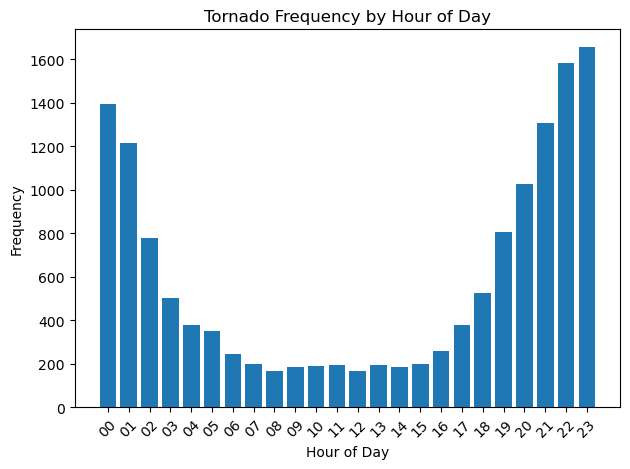

In [158]:
plt.bar(hour_counts.index, hour_counts.values)
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Tornado Frequency by Hour of Day')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [156]:
df['Time'] = df['Start Time'].str[11:13]

In [161]:
dfshort

,Path Length (mi),Path Width (yds),Injuries,Fatalities,00:00_Wind_Speed_10m,01:00_Wind_Speed_10m,02:00_Wind_Speed_10m,03:00_Wind_Speed_10m,04:00_Wind_Speed_10m,05:00_Wind_Speed_10m,06:00_Wind_Speed_10m,07:00_Wind_Speed_10m,08:00_Wind_Speed_10m,09:00_Wind_Speed_10m,10:00_Wind_Speed_10m,11:00_Wind_Speed_10m,12:00_Wind_Speed_10m,13:00_Wind_Speed_10m,14:00_Wind_Speed_10m,15:00_Wind_Speed_10m,16:00_Wind_Speed_10m,17:00_Wind_Speed_10m,18:00_Wind_Speed_10m,19:00_Wind_Speed_10m,20:00_Wind_Speed_10m,21:00_Wind_Speed_10m,22:00_Wind_Speed_10m,23:00_Wind_Speed_10m,00:00_Wind_Speed_100m,01:00_Wind_Speed_100m,02:00_Wind_Speed_100m,03:00_Wind_Speed_100m,04:00_Wind_Speed_100m,05:00_Wind_Speed_100m,06:00_Wind_Speed_100m,07:00_Wind_Speed_100m,08:00_Wind_Speed_100m,09:00_Wind_Speed_100m,10:00_Wind_Speed_100m,11:00_Wind_Speed_100m,12:00_Wind_Speed_100m,13:00_Wind_Speed_100m,14:00_Wind_Speed_100m,15:00_Wind_Speed_100m,16:00_Wind_Speed_100m,17:00_Wind_Speed_100m,18:00_Wind_Speed_100m,19:00_Wind_Speed_100m,20:00_Wind_Speed_100m,21:00_Wind_Speed_100m,22:00_Wind_Speed_100m,23:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Pressure_msl,02:00_Pressure_msl,03:00_Pressure_msl,04:00_Pressure_msl,05:00_Pressure_msl,06:00_Pressure_msl,07:00_Pressure_msl,08:00_Pressure_msl,09:00_Pressure_msl,10:00_Pressure_msl,11:00_Pressure_msl,12:00_Pressure_msl,13:00_Pressure_msl,14:00_Pressure_msl,15:00_Pressure_msl,16:00_Pressure_msl,17:00_Pressure_msl,18:00_Pressure_msl,19:00_Pressure_msl,20:00_Pressure_msl,21:00_Pressure_msl,22:00_Pressure_msl,23:00_Pressure_msl,labels,Time
1,2.38,175.0,1.0,0.0,7.628263,11.885453,16.099689,16.394829,16.516901,16.454008,17.057314,18.032370,19.093580,18.940241,20.316889,22.197729,18.782204,20.969805,22.702845,25.959969,28.082308,23.979893,23.584808,24.162945,19.917469,20.598795,19.813087,19.881649,19.665359,25.407431,30.500309,30.972555,31.079071,31.278593,32.078403,33.315079,34.321049,34.388950,35.870163,37.705597,33.184502,34.668579,35.632725,38.753124,43.063282,37.443459,36.712940,34.651752,28.714371,30.498180,31.035257,32.599388,1016.299988,1016.799988,1017.200012,1017.599976,1017.799988,1017.200012,1016.400024,1016.099976,1015.900024,1015.900024,1015.599976,1015.599976,1015.900024,1016.299988,1016.599976,1017.099976,1016.900024,1016.099976,1015.200012,1014.400024,1015.200012,1015.799988,1016.500000,1017.400024,1,15
2,4.39,265.0,0.0,0.0,5.483356,8.350138,11.183201,11.165805,11.792404,12.224107,13.004921,14.777550,15.546833,16.263872,16.750641,18.806337,17.771753,18.175545,19.562946,20.345573,22.171440,26.562046,21.434364,18.584509,16.676977,16.750641,16.520823,16.394829,16.243940,19.523155,24.442911,24.149532,25.171696,25.387020,26.339109,29.024128,29.834423,31.259945,31.630871,34.268143,31.782108,31.278593,32.587456,32.837051,33.851486,43.466175,34.623692,29.070974,25.420181,26.836306,28.054604,28.623962,1016.500000,1016.900024,1017.299988,1017.599976,1017.900024,1017.299988,1016.599976,1016.299988,1016.000000,1015.900024,1015.799988,1015.700012,1015.900024,1016.299988,1016.700012,1016.599976,1016.099976,1015.400024,1014.799988,1013.700012,1014.299988,1014.799988,1015.500000,1016.400024,1,16
3,1.30,10.0,0.0,0.0,15.807239,14.973577,18.511143,18.000000,17.298738,18.289274,19.296133,18.129137,17.339897,17.283749,19.110542,17.298738,17.057314,16.099689,13.479583,13.896187,9.504273,7.421590,13.513193,10.390226,8.557102,11.620809,3.096837,6.409617,29.301876,27.609911,33.971870,33.190357,32.023815,32.641102,33.603645,31.421213,30.608469,30.633865,33.119999,31.212229,31.338614,30.317043,25.992397,24.482647,16.781561,14.561099,24.192429,18.723459,17.253731,18.947083,2.160000,3.758510,1011.599976,1011.700012,1011.700012,1011.700012,1011.900024,1011.799988,1011.599976,1011.099976,1010.799988,1010.700012,1010.299988,1010.400024,1010.700012,1010.799988,1010.400024,1010.900024,1010.299988,1010.000000,1007.700012,1005.799988,1004.400024,1004.200012,1005.200012,1005.000000,1,16
4,1.00,50.0,0.0,0.0,7.903619,7.928178,7.993298,9.904906,7.895416,8.891344,

In [166]:
average_wind_speed_10m = []

# Iterate through each row of the DataFrame
for index, row in dfshort.iterrows():
    # Extract the hour from the 'Time' column
    hour = int(row['Time'])  # Convert the 'Time' column to an integer
    
    # Filter weather data columns up to the current hour
    wind_speed_columns = [col for col in dfshort.columns if col.endswith(':00_Wind_Speed_10m')]
    wind_speed_values = row[wind_speed_columns].iloc[:hour + 1]  # Filter columns up to the current hour
    
    # Calculate the average wind speed 10m up to the current hour
    average_wind_speed_10m.append(wind_speed_values.mean())

# Add the average wind speed 10m values to the DataFrame
dfshort['Leading_Average_Wind_Speed_10m'] = average_wind_speed_10m

C:\Users\15199\AppData\Local\Temp\ipykernel_18344\993683380.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfshort['Leading_Average_Wind_Speed_10m'] = average_wind_speed_10m


In [167]:
dfshort

,Path Length (mi),Path Width (yds),Injuries,Fatalities,00:00_Wind_Speed_10m,01:00_Wind_Speed_10m,02:00_Wind_Speed_10m,03:00_Wind_Speed_10m,04:00_Wind_Speed_10m,05:00_Wind_Speed_10m,06:00_Wind_Speed_10m,07:00_Wind_Speed_10m,08:00_Wind_Speed_10m,09:00_Wind_Speed_10m,10:00_Wind_Speed_10m,11:00_Wind_Speed_10m,12:00_Wind_Speed_10m,13:00_Wind_Speed_10m,14:00_Wind_Speed_10m,15:00_Wind_Speed_10m,16:00_Wind_Speed_10m,17:00_Wind_Speed_10m,18:00_Wind_Speed_10m,19:00_Wind_Speed_10m,20:00_Wind_Speed_10m,21:00_Wind_Speed_10m,22:00_Wind_Speed_10m,23:00_Wind_Speed_10m,00:00_Wind_Speed_100m,01:00_Wind_Speed_100m,02:00_Wind_Speed_100m,03:00_Wind_Speed_100m,04:00_Wind_Speed_100m,05:00_Wind_Speed_100m,06:00_Wind_Speed_100m,07:00_Wind_Speed_100m,08:00_Wind_Speed_100m,09:00_Wind_Speed_100m,10:00_Wind_Speed_100m,11:00_Wind_Speed_100m,12:00_Wind_Speed_100m,13:00_Wind_Speed_100m,14:00_Wind_Speed_100m,15:00_Wind_Speed_100m,16:00_Wind_Speed_100m,17:00_Wind_Speed_100m,18:00_Wind_Speed_100m,19:00_Wind_Speed_100m,20:00_Wind_Speed_100m,21:00_Wind_Speed_100m,22:00_Wind_Speed_100m,23:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Pressure_msl,02:00_Pressure_msl,03:00_Pressure_msl,04:00_Pressure_msl,05:00_Pressure_msl,06:00_Pressure_msl,07:00_Pressure_msl,08:00_Pressure_msl,09:00_Pressure_msl,10:00_Pressure_msl,11:00_Pressure_msl,12:00_Pressure_msl,13:00_Pressure_msl,14:00_Pressure_msl,15:00_Pressure_msl,16:00_Pressure_msl,17:00_Pressure_msl,18:00_Pressure_msl,19:00_Pressure_msl,20:00_Pressure_msl,21:00_Pressure_msl,22:00_Pressure_msl,23:00_Pressure_msl,labels,Time,Average_Wind_Speed_10m,Leading_Average_Wind_Speed_10m
1,2.38,175.0,1.0,0.0,7.628263,11.885453,16.099689,16.394829,16.516901,16.454008,17.057314,18.032370,19.093580,18.940241,20.316889,22.197729,18.782204,20.969805,22.702845,25.959969,28.082308,23.979893,23.584808,24.162945,19.917469,20.598795,19.813087,19.881649,19.665359,25.407431,30.500309,30.972555,31.079071,31.278593,32.078403,33.315079,34.321049,34.388950,35.870163,37.705597,33.184502,34.668579,35.632725,38.753124,43.063282,37.443459,36.712940,34.651752,28.714371,30.498180,31.035257,32.599388,1016.299988,1016.799988,1017.200012,1017.599976,1017.799988,1017.200012,1016.400024,1016.099976,1015.900024,1015.900024,1015.599976,1015.599976,1015.900024,1016.299988,1016.599976,1017.099976,1016.900024,1016.099976,1015.200012,1014.400024,1015.200012,1015.799988,1016.500000,1017.400024,1,15,18.064505,18.064505
2,4.39,265.0,0.0,0.0,5.483356,8.350138,11.183201,11.165805,11.792404,12.224107,13.004921,14.777550,15.546833,16.263872,16.750641,18.806337,17.771753,18.175545,19.562946,20.345573,22.171440,26.562046,21.434364,18.584509,16.676977,16.750641,16.520823,16.394829,16.243940,19.523155,24.442911,24.149532,25.171696,25.387020,26.339109,29.024128,29.834423,31.259945,31.630871,34.268143,31.782108,31.278593,32.587456,32.837051,33.851486,43.466175,34.623692,29.070974,25.420181,26.836306,28.054604,28.623962,1016.500000,1016.900024,1017.299988,1017.599976,1017.900024,1017.299988,1016.599976,1016.299988,1016.000000,1015.900024,1015.799988,1015.700012,1015.900024,1016.299988,1016.700012,1016.599976,1016.099976,1015.400024,1014.799988,1013.700012,1014.299988,1014.799988,1015.500000,1016.400024,1,16,14.904495,14.904495
3,1.30,10.0,0.0,0.0,15.807239,14.973577,18.511143,18.000000,17.298738,18.289274,19.296133,18.129137,17.339897,17.283749,19.110542,17.298738,17.057314,16.099689,13.479583,13.896187,9.504273,7.421590,13.513193,10.390226,8.557102,11.620809,3.096837,6.409617,29.301876,27.609911,33.971870,33.190357,32.023815,32.641102,33.603645,31.421213,30.608469,30.633865,33.119999,31.212229,31.338614,30.317043,25.992397,24.482647,16.781561,14.561099,24.192429,18.723459,17.253731,18.947083,2.160000,3.758510,1011.599976,1011.700012,1011.700012,1011.700012,1011.900024,1011.799988,1011.599976,1011.099976,1010.799988,1010.700012,1010.299988,1010.400024,1010.700012,1010.799988,1010.400024,1010.900024,1010.299988,1010.000000,1007.700012,1005.799988,1004.400024,1004.200012,1005.2000

In [172]:
X = dfshort[['Path Width (yds)', 'Injuries', 'Fatalities','Path Length (mi)']]
y = dfshort['Average_Wind_Speed_10m']

X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()

In [173]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Average_Wind_Speed_10m   R-squared:                       0.011
Model:                                OLS   Adj. R-squared:                  0.009
Method:                     Least Squares   F-statistic:                     6.627
Date:                    Tue, 09 Apr 2024   Prob (F-statistic):           2.66e-05
Time:                            17:15:31   Log-Likelihood:                -8358.6
No. Observations:                    2401   AIC:                         1.673e+04
Df Residuals:                        2396   BIC:                         1.676e+04
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               17.2208      0.195     88.133      0.000      16.838      17.604
Path Width (yds)    -0.0023      0.001     -2.806      0.005      -0.004      -0.001
Injuries            -0.0548      0.032     -1.691      0.091      -0.118       0.009
Fatalities           0.2785      0.279      0.997      0.319      -0.269       0.826
Path Length (mi)     0.1566      0.032      4.944      0.000       0.094       0.219
==============================================================================
Omnibus:                      659.401   Durbin-Watson:                   0.568
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2281.746
Skew:                           1.343   Prob(JB):                         0.00
Kurtosis:                       6.949   Cond. No.                         531.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
df = pd.read_csv('data/spc.csv')
df = df[df['yr'] >= 1996]
df = df.dropna()
df.drop(columns=['om','tz','stn','ns','sn','sg','f1','f2','f3','f4','fc'], inplace=True)

In [54]:
#set to next bracket
#here
dfsubset1 = df.iloc[30000:]

In [56]:
for index, row in dfsubset1.iterrows():
    # Extract latitude, longitude, and start time from the row
    latitude = row['slat']
    longitude = row['slon']
    start_time = row['date']  # Take the first 10 characters of the start time

    # Make API request to retrieve weather data
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_time,
        "end_date": start_time,
        "hourly": "wind_speed_10m,wind_speed_100m,pressure_msl"  # Request multiple weather parameters
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process the response
    response = responses[0]
    hourly = response.Hourly()
    
    # Extract values for each parameter
    wind_speed_10m_values = hourly.Variables(0).ValuesAsNumpy()
    wind_speed_100m_values = hourly.Variables(1).ValuesAsNumpy()
    pressure_msl_values = hourly.Variables(2).ValuesAsNumpy()

    # Add wind speed and pressure data as columns to the DataFrame, starting from 00:00
    for i in range(len(wind_speed_10m_values)):
        hour_str = f"{i:02d}:00"  # Format hour as HH:00
        column_name_10m = f"{hour_str}_Wind_Speed_10m"
        column_name_100m = f"{hour_str}_Wind_Speed_100m"
        column_name_pressure = f"{hour_str}_Pressure_msl"
        
        # Assign values to corresponding columns
        dfsubset1.loc[index, column_name_10m] = wind_speed_10m_values[i]
        dfsubset1.loc[index, column_name_100m] = wind_speed_100m_values[i]
        dfsubset1.loc[index, column_name_pressure] = pressure_msl_values[i]

C:\Users\15199\AppData\Local\Temp\ipykernel_15920\2390064013.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsubset1.loc[index, column_name_10m] = wind_speed_10m_values[i]
C:\Users\15199\AppData\Local\Temp\ipykernel_15920\2390064013.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsubset1.loc[index, column_name_100m] = wind_speed_100m_values[i]
C:\Users\15199\AppData\Local\Temp\ipykernel_15920\2390064013.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [57]:
dfsubset1.dropna()

,yr,mo,dy,date,time,st,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,00:00_Wind_Speed_10m,00:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Wind_Speed_10m,01:00_Wind_Speed_100m,01:00_Pressure_msl,02:00_Wind_Speed_10m,02:00_Wind_Speed_100m,02:00_Pressure_msl,03:00_Wind_Speed_10m,03:00_Wind_Speed_100m,03:00_Pressure_msl,04:00_Wind_Speed_10m,04:00_Wind_Speed_100m,04:00_Pressure_msl,05:00_Wind_Speed_10m,05:00_Wind_Speed_100m,05:00_Pressure_msl,06:00_Wind_Speed_10m,06:00_Wind_Speed_100m,06:00_Pressure_msl,07:00_Wind_Speed_10m,07:00_Wind_Speed_100m,07:00_Pressure_msl,08:00_Wind_Speed_10m,08:00_Wind_Speed_100m,08:00_Pressure_msl,09:00_Wind_Speed_10m,09:00_Wind_Speed_100m,09:00_Pressure_msl,10:00_Wind_Speed_10m,10:00_Wind_Speed_100m,10:00_Pressure_msl,11:00_Wind_Speed_10m,11:00_Wind_Speed_100m,11:00_Pressure_msl,12:00_Wind_Speed_10m,12:00_Wind_Speed_100m,12:00_Pressure_msl,13:00_Wind_Speed_10m,13:00_Wind_Speed_100m,13:00_Pressure_msl,14:00_Wind_Speed_10m,14:00_Wind_Speed_100m,14:00_Pressure_msl,15:00_Wind_Speed_10m,15:00_Wind_Speed_100m,15:00_Pressure_msl,16:00_Wind_Speed_10m,16:00_Wind_Speed_100m,16:00_Pressure_msl,17:00_Wind_Speed_10m,17:00_Wind_Speed_100m,17:00_Pressure_msl,18:00_Wind_Speed_10m,18:00_Wind_Speed_100m,18:00_Pressure_msl,19:00_Wind_Speed_10m,19:00_Wind_Speed_100m,19:00_Pressure_msl,20:00_Wind_Speed_10m,20:00_Wind_Speed_100m,20:00_Pressure_msl,21:00_Wind_Speed_10m,21:00_Wind_Speed_100m,21:00_Pressure_msl,22:00_Wind_Speed_10m,22:00_Wind_Speed_100m,22:00_Pressure_msl,23:00_Wind_Speed_10m,23:00_Wind_Speed_100m,23:00_Pressure_msl
65431,2020,3,2,2020-03-02,22:41:00,TN,47,2,0,0,5.000000e+05,0.0,36.0811,-88.5287,36.0792,-88.2637,14.80,100,18.888851,33.315079,1014.000000,15.517629,30.703587,1014.799988,18.455048,34.366333,1016.200012,16.235960,30.993471,1015.900024,15.978484,32.241615,1015.299988,17.782688,33.244980,1014.700012,16.099689,30.344814,1014.200012,15.158522,29.237675,1013.799988,17.654688,33.449017,1013.000000,17.106628,31.983318,1012.400024,16.454008,30.821548,1012.099976,13.627795,27.663839,1012.299988,13.684735,26.339109,1010.900024,13.237039,26.576681,1010.400024,15.188416,28.757215,1011.099976,14.480773,26.319420,1011.000000,17.309975,28.515089,1010.900024,19.161337,29.784426,1010.400024,17.877180,27.055143,1009.799988,17.388409,26.242987,1008.599976,15.696165,24.272650,1008.099976,13.324863,20.808498,1007.599976,9.693296,15.683774,1006.599976,10.365251,21.422270,1006.400024
65432,2020,3,2,2020-03-02,23:05:00,TN,47,2,2,1,1.100000e+06,300000.0,36.0928,-88.1189,36.1074,-87.7838,18.72,250,19.353140,35.186199,1014.500000,17.313717,33.121956,1014.900024,14.578888,29.035288,1016.099976,14.689589,28.483259,1016.700012,14.345898,30.244286,1016.099976,16.311613,32.793610,1015.400024,15.596767,29.686359,1014.599976,15.496736,29.934166,1014.299988,17.313717,32.379990,1013.700012,18.532133,34.388950,1012.700012,17.651016,32.396000,1012.500000,15.192682,29.175552,1012.700012,14.777550,28.137634,1011.299988,13.797912,26.632700,1010.799988,15.596767,29.024128,1011.500000,15.141414,26.260265,1011.400024,16.676977,28.082308,1011.200012,16.595179,28.043051,1010.799988,17.287498,26.980793,1010.099976,17.068707,25.772078,1008.799988,15.683774,23.893261,1008.299988,9.931042,16.363178,1007.799988,10.829959,17.873554,1007.000000,10.446206,20.991426,1006.700012
65433,2020,3,2,2020-03-02,23:42:00,TN,47,0,0,0,2.500000e+04,25000.0,36.1162,-87.6482,36.1231,-87.5629,4.80,50,18.511143,34.034760,1015.200012,17.227419,33.202072,1015.299988,16.199999,32.048088,1016.099976,15.256526,30.421598,1017.000000,15.124284,28.943642,1017.000000,16.516901,33.041645,1016.299988,18.057508,33.834255,1015.299988,17.771753,33.121956,1015.000000,18.391735,34.114628,1014.400024,19.881649,35.994598,1013.299988,16.750641,31.630871,1013.099976,17.581125,31.869658,1013.200012,16.563911,30.293522,1011.900024,14.973576,28.551426,1011.400024,17.533146,31.353088,1012.000000,16.781561,29.317352,1011.900024,16.595179,27.532352,1011.799988,18.892282,29.574827,1011.

In [58]:
dfsubset1.to_csv('data/weather7.csv')

In [23]:
pre_weather_cols = dfsubset1.columns[:17]  # Adjust index_of_first_weather_data accordingly

# Identify columns for wind speed 10m, wind speed 100m, and pressure
wind_speed_10m_cols = [col for col in dfsubset1.columns if col.endswith('_Wind_Speed_10m')]
wind_speed_100m_cols = [col for col in dfsubset1.columns if col.endswith('_Wind_Speed_100m')]
pressure_cols = [col for col in dfsubset1.columns if col.endswith('_Pressure_msl')]

# Extract values for each weather factor
wind_speed_10m_values = dfsubset1[wind_speed_10m_cols].values
wind_speed_100m_values = dfsubset1[wind_speed_100m_cols].values
pressure_values = dfsubset1[pressure_cols].values

# Reshape the values into a row-wise format
num_rows = len(dfsubset1)
num_cols = len(wind_speed_10m_cols) + len(wind_speed_100m_cols) + len(pressure_cols)
reshaped_values = np.empty((num_rows, num_cols))
for i in range(num_rows):
    row_values = np.concatenate([wind_speed_10m_values[i], wind_speed_100m_values[i], pressure_values[i]])
    reshaped_values[i] = row_values

# Create a DataFrame with reshaped weather data
new_columns = wind_speed_10m_cols + wind_speed_100m_cols + pressure_cols
df_weather_reshaped = pd.DataFrame(data=reshaped_values, columns=new_columns)

# Concatenate the extracted columns with the reshaped weather data
df_combined = pd.concat([dfsubset1[pre_weather_cols], df_weather_reshaped], axis=1)

In [53]:
df_combined

,yr,mo,dy,date,time,st,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,00:00_Wind_Speed_10m,01:00_Wind_Speed_10m,02:00_Wind_Speed_10m,03:00_Wind_Speed_10m,04:00_Wind_Speed_10m,05:00_Wind_Speed_10m,06:00_Wind_Speed_10m,07:00_Wind_Speed_10m,08:00_Wind_Speed_10m,09:00_Wind_Speed_10m,10:00_Wind_Speed_10m,11:00_Wind_Speed_10m,12:00_Wind_Speed_10m,13:00_Wind_Speed_10m,14:00_Wind_Speed_10m,15:00_Wind_Speed_10m,16:00_Wind_Speed_10m,17:00_Wind_Speed_10m,18:00_Wind_Speed_10m,19:00_Wind_Speed_10m,20:00_Wind_Speed_10m,21:00_Wind_Speed_10m,22:00_Wind_Speed_10m,23:00_Wind_Speed_10m,00:00_Wind_Speed_100m,01:00_Wind_Speed_100m,02:00_Wind_Speed_100m,03:00_Wind_Speed_100m,04:00_Wind_Speed_100m,05:00_Wind_Speed_100m,06:00_Wind_Speed_100m,07:00_Wind_Speed_100m,08:00_Wind_Speed_100m,09:00_Wind_Speed_100m,10:00_Wind_Speed_100m,11:00_Wind_Speed_100m,12:00_Wind_Speed_100m,13:00_Wind_Speed_100m,14:00_Wind_Speed_100m,15:00_Wind_Speed_100m,16:00_Wind_Speed_100m,17:00_Wind_Speed_100m,18:00_Wind_Speed_100m,19:00_Wind_Speed_100m,20:00_Wind_Speed_100m,21:00_Wind_Speed_100m,22:00_Wind_Speed_100m,23:00_Wind_Speed_100m,00:00_Pressure_msl,01:00_Pressure_msl,02:00_Pressure_msl,03:00_Pressure_msl,04:00_Pressure_msl,05:00_Pressure_msl,06:00_Pressure_msl,07:00_Pressure_msl,08:00_Pressure_msl,09:00_Pressure_msl,10:00_Pressure_msl,11:00_Pressure_msl,12:00_Pressure_msl,13:00_Pressure_msl,14:00_Pressure_msl,15:00_Pressure_msl,16:00_Pressure_msl,17:00_Pressure_msl,18:00_Pressure_msl,19:00_Pressure_msl,20:00_Pressure_msl,21:00_Pressure_msl,22:00_Pressure_msl,23:00_Pressure_msl
35431,1996.0,10.0,17.0,1996-10-17,17:40:00,IL,17.0,0.0,1.0,0.0,0.00,0.0,39.33,-88.45,39.33,-88.40,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35432,1996.0,10.0,21.0,1996-10-21,07:00:00,TX,48.0,1.0,0.0,0.0,0.04,0.0,32.40,-97.80,32.40,-97.80,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35433,1996.0,10.0,21.0,1996-10-21,08:35:00,TX,48.0,1.0,7.0,0.0,3.00,0.0,32.77,-96.78,32.77,-96.78,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35434,1996.0,10.0,21.0,1996-10-21,08:45:00,TX,48.0,0.0,1.0,0.0,0.12,0.0,32.77,-96.60,32.77,-96.60,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35435,1996.0,10.0,21.0,1996-10-21,10:10:00,TX,48.0,0.0,0.0,0.0,0.00,0.0,32.47,-98.42,32.47,-98.42,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.678415,14.843180,11.874544,10.105681,11.200571,11.75